In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [109]:
df = pd.read_csv(
    r'TOI_2025.10.05_08.35.22.csv',
    sep=None,            # auto-detect delimiter
    engine='python',     # use the Python engine for flexibility
    # on_bad_lines='skip'  # skip malformed lines
    skiprows=69
)

# Check first few rows
df.head()

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01


In [110]:
df.columns = df.columns.str.strip()
target = 'tfopwg_disp'

features = [
    'pl_orbper',
    'pl_trandurh',
    'pl_trandep',
    'pl_rade',
    'pl_insol',
    'pl_eqt',
    'st_teff',
    'st_logg',
    'st_rad',
    'ra',
    'dec',
    'st_pmra',
    'st_pmdec',
    'st_tmag',
    'st_dist'
]

cols_to_use = [col for col in features + [target] if col in df.columns]
df_model = df[cols_to_use].copy()
df_model = df_model.dropna()

le = LabelEncoder()
df_model['label'] = le.fit_transform(df_model[target])

In [111]:
y = df_model['label']
X = df_model.drop(columns=[target, 'label'])

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV # Switching back to full Grid Search for this test

# Assume X_train, y_train, X_val, y_val are defined

# Define a comprehensive parameter grid
param_grid_comprehensive = {
    # n_estimators: Try higher counts, as they often improve performance up to a point
    'n_estimators': [300, 500, 800], 
    
    # max_depth: Focused on medium/deep trees, excluding None for a more controlled search
    'max_depth': [15, 25, 40], 
    
    # min_samples_leaf: Controls the minimum number of samples at a leaf node (a strong regularizer)
    'min_samples_leaf': [1, 3, 5], 
    
    # max_features: The number of features to consider when looking for the best split
    'max_features': [0.6, 0.8, 'sqrt'], # Try percentages and 'sqrt'
    
    # max_samples: The fraction of samples to draw from X to train each base estimator (Bagging parameter)
    'max_samples': [0.7, 0.9, None] # None means use all samples
}

# The combination of these parameters will lead to a very large search space (3*3*3*3*3 = 243 fits), 
# which is why we often use RandomizedSearch first. But let's run it on a small cross-validation set 
# or use a limited number of the combinations if performance is an issue.

# For simplicity, sticking to the manual validation loop for now, 
# but be aware this combination is a lot of runs!

best_acc_broad = 0
best_params_broad = {}

for n in param_grid_comprehensive['n_estimators']:
    for d in param_grid_comprehensive['max_depth']:
        for l in param_grid_comprehensive['min_samples_leaf']:
            for mf in param_grid_comprehensive['max_features']:
                for ms in param_grid_comprehensive['max_samples']:
                    clf = RandomForestClassifier(n_estimators=n, max_depth=d, 
                                                 min_samples_leaf=l, max_features=mf,
                                                 max_samples=ms,
                                                 random_state=42, class_weight='balanced')
                    clf.fit(X_train, y_train)
                    y_val_pred = clf.predict(X_val)
                    acc = accuracy_score(y_val, y_val_pred)
                    
                    # Log only the best to reduce print clutter
                    if acc > best_acc_broad:
                        best_acc_broad = acc
                        best_params_broad = {'n_estimators': n, 'max_depth': d, 
                                             'min_samples_leaf': l, 'max_features': mf,
                                             'max_samples': ms}

print(f"Current Best Broad Validation Accuracy: {best_acc_broad}")
print("Current Best Broad Hyperparameters:", best_params_broad)

Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.32      0.32        71
           1       0.52      0.58      0.55       133
           2       0.33      0.08      0.12        13
           3       0.46      0.52      0.49       188
           4       0.48      0.53      0.50       112
           5       0.80      0.76      0.78       801

    accuracy                           0.66      1318
   macro avg       0.48      0.46      0.46      1318
weighted avg       0.66      0.66      0.66      1318



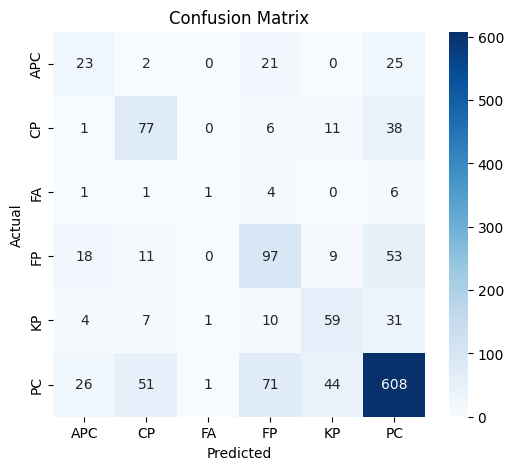

In [ ]:
y_test_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


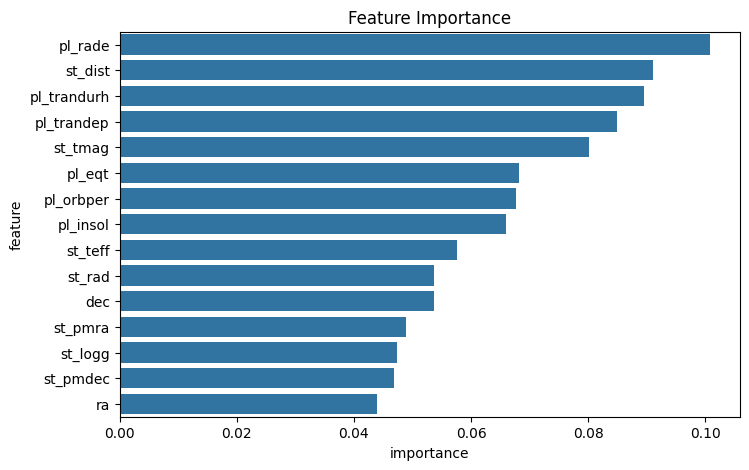

Feature importances (highest to lowest):
pl_rade: 0.1008
st_dist: 0.0911
pl_trandurh: 0.0895
pl_trandep: 0.0849
st_tmag: 0.0802
pl_eqt: 0.0682
pl_orbper: 0.0676
pl_insol: 0.0660
st_teff: 0.0576
st_rad: 0.0537
dec: 0.0536
st_pmra: 0.0489
st_logg: 0.0473
st_pmdec: 0.0468
ra: 0.0439


In [ ]:
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

print("Feature importances (highest to lowest):")
for i, row in feature_importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


Final Test Set Classification Report:

              precision    recall  f1-score   support

         APC       0.54      0.10      0.17        71
          CP       0.70      0.37      0.48       133
          FA       0.00      0.00      0.00        13
          FP       0.51      0.38      0.44       188
          KP       0.78      0.41      0.54       112
          PC       0.72      0.93      0.81       801

    accuracy                           0.70      1318
   macro avg       0.54      0.37      0.41      1318
weighted avg       0.68      0.70      0.66      1318



c:\Users\aiman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aiman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aiman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

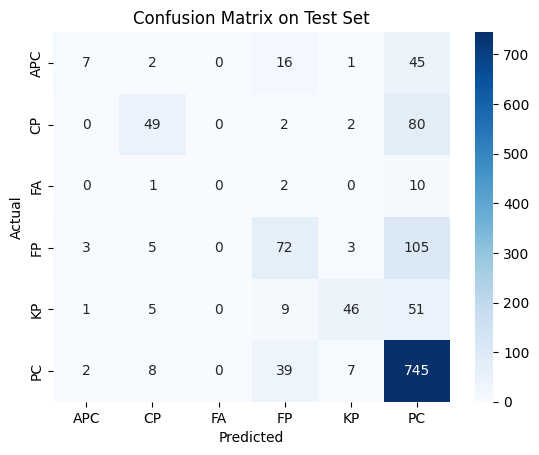

In [ ]:
clf_final = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42
)

clf_final.fit(X_train, y_train)

y_test_pred = clf_final.predict(X_test)


print("Final Test Set Classification Report:\n")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Plot the confusion matrix for the test set results
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()